In [147]:
import pandas as pd
import plotly.graph_objects as go
import re
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, roc_auc_score, recall_score, ConfusionMatrixDisplay, classification_report,balanced_accuracy_score
from plotly.subplots import make_subplots
import os

In [148]:
# own_data = pd.read_csv("../../datasets/dessi-mf/dessi-mf/test.csv")
# own_data_personal = pd.read_csv("../../datasets/dessi-mf/dessi-mf/test_labels_personal.csv")
# own_data_classes = pd.read_csv("../../datasets/dessi-mf/dessi-mf/test_classes.csv")
# own_data_datasets = pd.read_csv("../../datasets/dessi-mf/dessi-mf/test_dataset.csv")

In [149]:
def extract_prediction(i, predictions):
    list_extractor = re.compile(r"([a-zA-Z0-9\-]+)\s*\(\d+(\.\d+)?\)")
    matches = list_extractor.findall(predictions.iloc[i, :].values[0])
    return [match[0] for match in matches]


def convert_predictions(predictions):
    column_names = []
    gold_list = []
    pred_list = []
    mismatch = []
    column_names.append(predictions.columns[0].split(". ")[0].strip())

    height = predictions.shape[0]

    for i in range(height):
        if 'Gold:' in predictions.iloc[i, :].values[0][:10]:
            gold_list.append(str(extract_prediction(i, predictions))[2:-2])
        elif 'Pred:' in predictions.iloc[i, :].values[0][:10]:
            pred_list.append(str(extract_prediction(i, predictions))[2:-2])
            if i == height-1:
                mismatch.append("No Mismatch")
                break
            if 'MISMATCH' in predictions.iloc[i+1, :].values[0][:20]:
                mismatch.append("Mismatch")
            else:
                mismatch.append("No Mismatch")
        elif 'MISMATCH' not in predictions.iloc[i, :].values[0][:20]:
            column_names.append(predictions.iloc[i, :].values[0].split('. ')[0].strip())
            
    df = pd.DataFrame({
        'Name': column_names,
        'Gold': gold_list,
        'Pred': pred_list,
        'Mismatch': mismatch
    })
    return df

In [150]:
# results_own_data = pd.read_csv("../CASSED_model_results/cassed_personal/dessi-mf/test.tsv", sep='\t')
# results_own_data = convert_predictions(results_own_data)

In [151]:
def plot_cassed_results(y_true,y_pred):
    y_true_bin = [1 if label == "personal" else 0 for label in y_true]
    y_pred_bin = [1 if label == "personal" else 0 for label in y_pred]

    cm = confusion_matrix(y_true, y_pred, labels=["personal", "non-personal"])
    cm_norm = confusion_matrix(y_true, y_pred, labels=["personal", "non-personal"], normalize="true")

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred,average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_true, y_pred, average="weighted")
    auc_roc = roc_auc_score(y_true_bin, y_pred_bin)

    fig = make_subplots(
        rows=1, cols=2, 
        subplot_titles=["Evaluation Metrics", "Confusion Matrix"]
    )

    metrics = {
        "weighted Precision": precision,
        "weighted Recall": recall,
        "weighted F1 Score": f1,
        "Accuracy": accuracy,
        "AUC-ROC": auc_roc
    }

    fig.add_trace(go.Bar(
        x=list(metrics.keys()),
        y=list(metrics.values()), 
        showlegend=False
    ), row=1, col=1)

    text_values = [
        [f"{cm[0,0]}<br>{cm_norm[0,0]:.2f}", f"{cm[0,1]}<br>{cm_norm[0,1]:.2f}"],
        [f"{cm[1,0]}<br>{cm_norm[1,0]:.2f}", f"{cm[1,1]}<br>{cm_norm[1,1]:.2f}"]
    ]
    cm_heatmap = go.Heatmap(
        z=cm, 
        x=["Pred: personal", "Pred: non-personal"], 
        y=["True: personal", "True: non-personal"], 
        colorscale="Blues", 
        showscale=False,
        text=text_values, 
        texttemplate="%{text}",
        textfont={"size":20},
    )


    fig.add_trace(cm_heatmap, row=1, col=2)

    fig.update_layout(
        title="Confusion Matrix and Evaluation Metrics",
        height=500, 
        width=1000,
        showlegend=False
    )
    fig.update_yaxes(range=[0, 1.1], row=1, col=1)

    fig.show()


In [152]:
# results_df_own_data = pd.DataFrame({
#     "Column": results_own_data["Name"],
#     "Prediction": results_own_data["Pred"],
#     "True Label": results_own_data["Gold"],
#     "Classes": own_data_classes["class"],
#     "Dataset": own_data_datasets["dataset"]
# })

In [153]:
# plot_cassed_results(results_own_data["Gold"], results_own_data["Pred"])

In [154]:
# #False negatives
# results_df_own_data.loc[(results_df_own_data["True Label"] == "personal") & (results_df_own_data["Prediction"] == "non-personal")]

In [155]:
# #False positives
# results_df_own_data.loc[(results_df_own_data["True Label"] == "non-personal") & (results_df_own_data["Prediction"] == "personal")]

In [156]:
# CLASS_NAMES = results_df_own_data["Classes"].unique()
# CLASS_NAMES = [a.lower().split("_")[0] for a in CLASS_NAMES]

# def is_valid_word(word):
#     return word.lower().split("_")[0] in CLASS_NAMES

def create_analysis_plot(results_df, dataset="dessi-mf"):
    cla_new, lan = [], []
    for i in range(len(results_df["Classes"])):
        if "mixed" in results_df.iloc[i, 3] or "de_DE" in results_df.iloc[i, 3] or "fr_FR" in results_df.iloc[i, 3]:
            cla_new.append(results_df.iloc[i, 3][:-6])
        elif "_en" in results_df.iloc[i, 3] or "_de" in results_df.iloc[i, 3] or "_fr" in results_df.iloc[i, 3] or "_it" in results_df.iloc[i,3
                                                                        ] or "_zh" in results_df.iloc[i,3]:
            cla_new.append(results_df.iloc[i, 3][:-3])
        else:
            cla_new.append(results_df.iloc[i, 3])
            
        if "mixed" in results_df.iloc[i, 3]:
            lan.append("mixed language")
        elif "_fr" == results_df.iloc[i,3][-3:].lower():
            lan.append("french")
        elif "_it" == results_df.iloc[i,3][-3:].lower():
            lan.append("italian")
        elif "_zh" == results_df.iloc[i,3][-3:].lower():
            lan.append("chinese")
        elif "_de" == results_df.iloc[i,3][-3:].lower():
            lan.append("german")
        elif "_en" == results_df.iloc[i,3][-3:].lower():
            lan.append("english")
        else:
            lan.append("dessi data")
    results_df["Classes_new"] = cla_new
    results_df["Language"] = lan
    

    accuracies_lan = {}
    for i in results_df["Language"].unique():
        lan_df = results_df.loc[results_df["Language"] == i]
        accuracies_lan[i] = accuracy_score(lan_df["True Label"], lan_df["Prediction"])
    accuracies_cla = {}
    for i in results_df["Classes_new"].unique():
        cla_df = results_df.loc[results_df["Classes_new"] == i]
        accuracies_cla[i] = accuracy_score(cla_df["True Label"], cla_df["Prediction"])
    accuracies_dat = {}
    for i in results_df["Dataset"].unique():
        dat_df = results_df.loc[results_df["Dataset"] == i]
        accuracies_dat[i] = accuracy_score(dat_df["True Label"], dat_df["Prediction"])
    accuracies_col = {}
    ind = []
    for i in range(results_df.shape[0]):
        if is_valid_word(results_df.iloc[i, 0]):
            ind.append(i)
    accuracies_col["valid_col_names"] = accuracy_score(results_df.iloc[ind, 2], results_df.iloc[ind, 1])
    accuracies_col["invalid_col_names"] = accuracy_score(results_df.iloc[[a for a in range(results_df.shape[0]) if a not in ind], 2], 
                                                        results_df.iloc[[a for a in range(results_df.shape[0]) if a not in ind], 1])

    accuracies_cla = dict(sorted(accuracies_cla.items(), key=lambda item: item[1], reverse=True))
    accuracies_lan = dict(sorted(accuracies_lan.items(), key=lambda item: item[1], reverse=True))
    accuracies_col = dict(sorted(accuracies_col.items(), key=lambda item: item[1], reverse=True))
    accuracies_dat = dict(sorted(accuracies_dat.items(), key=lambda item: item[1], reverse=True))


    fig = make_subplots(rows=3, cols=1, subplot_titles=["Accuracy per Class", "Number of correct predictions per Class", "Number of false predictions per Class"],
                        shared_xaxes=True)
    fig.add_trace(go.Bar(
        x=list(accuracies_cla.keys()),
        y=list(accuracies_cla.values()),
        marker=dict(color="black"),
        showlegend=False
    ))
    
    colors = [
    "#d62728",  # Red (High Saturation)
    "#ff9896",  # Red (Low Saturation)
    "#1f77b4",  # Blue (High Saturation)
    "#aec7e8",  # Blue (Low Saturation)
    "#ff7f0e",  # Orange (High Saturation)
    "#ffbb78",  # Orange (Low Saturation)
    "#2ca02c",  # Green (High Saturation)
    "#98df8a",  # Green (Low Saturation)
    "#9467bd",  # Purple (High Saturation)
    "#c5b0d5",  # Purple (Low Saturation)
    ]

    languages = ['english', 'french', 'german', 'mixed language', 'dessi data'] if dataset != "two languages" else ["italian", "chinese"]
    for bool_val in [True, False]:
        for e, language in enumerate(languages):
            lan_df = results_df.loc[results_df["Language"] == language]
            accuracies_cla = {}
            for ee, col_valid in enumerate([True, False]):
                percentage_of_this_language = []
                for i in lan_df["Classes_new"].unique():
                    cla_df = lan_df.loc[lan_df["Classes_new"] == i]
                    ind = []
                    for j in range(cla_df.shape[0]):
                        if is_valid_word(cla_df.iloc[j, 0]) == col_valid:
                            ind.append(j)
                    cla_df = cla_df.iloc[ind,:]
                    percentage_of_this_language.append(cla_df.shape[0] / results_df.loc[results_df["Classes_new"] == i].shape[0])
                    accuracies_cla[i] = (cla_df["True Label"] == cla_df["Prediction"]).value_counts(normalize=True).get(bool_val, 0)
                fig.add_trace(go.Bar(
                    x=list(accuracies_cla.keys()),
                    y=[a * b for a, b in zip(list(accuracies_cla.values()), percentage_of_this_language)],
                    marker=dict(color=colors[2*e+ee]),
                    name=f"{language}_" + ("valid" if col_valid == True else "invalid") + "<br>column name",
                    showlegend=True if bool_val == True else False,
                    legendgroup=2*e+ee
                ), row=2 if bool_val == True else 3, col=1)
    fig.update_layout(title=f"Accuracy per Class for CASSED's personal Predictions on {dataset}", width=1500, height=700, barmode="stack")
    fig.update_yaxes(title_text="Accuracy", row=1, col=1)
    fig.update_yaxes(title_text="Amount of<br>correct predictions", row=2, col=1)
    fig.update_yaxes(title_text="Amount of<br>false predictions", row=3, col=1)
    fig.show()

    fig = make_subplots(
        rows=1, cols=3, shared_yaxes=True,
        subplot_titles=["Accuracy per Language", "Accuracy per Dataset", "Accuracy per Column Name"]
    )
    fig.add_trace(go.Bar(
        x=list(accuracies_lan.keys()),
        y=list(accuracies_lan.values()),
        showlegend=False
    ), row=1, col=1)
    fig.add_trace(go.Bar(
        x=list(accuracies_dat.keys()),
        y=list(accuracies_dat.values()),
        showlegend=False
    ), row=1, col=2)
    fig.add_trace(go.Bar(
        x=list(accuracies_col.keys()),
        y=list(accuracies_col.values()),
        showlegend=False
    ), row=1, col=3)
    fig.update_layout(width=900, height=500, title=f"Accuracy of CASSED's personal Predictions on {dataset} with respect to different categories")
    fig.show()

In [157]:
# create_analysis_plot(results_df_own_data)

# Test two languages

In [158]:
# test_lan = pd.read_csv("../../datasets/test_languages/test.csv")
# test_lan_personal = pd.read_csv("../../datasets/test_languages/test_labels_personal.csv")
# test_lan_classes = pd.read_csv("../../datasets/test_languages/test_classes.csv")
# test_lan_datasets = pd.read_csv("../../datasets/test_languages/test_dataset.csv")

In [159]:
# two_lan_true = pd.read_csv("../CASSED_model_results/cassed_personal/two_languages/true.csv")
# two_lan_pred = pd.read_csv("../CASSED_model_results/cassed_personal/two_languages/predicted.csv")
# two_lan_target_names = pd.read_csv("../CASSED_model_results/cassed_personal/two_languages/target_names.csv")
# two_lan_target_names = {a[1]: a[0] for a in two_lan_target_names[["0", "0.1"]].values}
# two_lan_target_names[0] = "no prediction"

In [160]:
# predictions, true = [], []
# for i in range(two_lan_true.shape[0]):
#     predictions.append([two_lan_target_names[e] for e, b in enumerate(two_lan_pred.iloc[i,:]) if b == 1])
#     true.append([two_lan_target_names[e] for e, b in enumerate(two_lan_true.iloc[i,:]) if b == 1])
# true = [a[0] for a in true]
# predictions = [a[0] for a in predictions]

In [161]:
# plot_cassed_results(true, predictions)

In [162]:
# results_df_test_lan = pd.DataFrame({
#     "Column": test_lan.columns,
#     "Prediction": predictions,
#     "True Label": test_lan_personal["label"].values,
#     "Classes": test_lan_classes["class"],
#     "Dataset": test_lan_datasets["dataset"]
# })

In [163]:
# #False negatives
# fn_df = results_df_test_lan.loc[(results_df_test_lan["True Label"] == "personal") & (results_df_test_lan["Prediction"] == "non-personal")]
# fn_df

In [164]:
# #False positives
# results_df_test_lan.loc[(results_df_test_lan["True Label"] == "non-personal") & (results_df_test_lan["Prediction"] == "personal")]

In [165]:
# create_analysis_plot(results_df_test_lan, dataset="two languages")

# DESSI ORIGINAL 

## DESSI TEST CLEANED

In [166]:
import os

absolute_path = "/home/aagisha/Documents/PhD Albert/CodingPhDStart1/WorkshopSIGMOD/Personal-Detection/CASSED/CASSED_model_results/cassed_personal/dessi_cleaned/target_names.csv"

# Get relative path from the current working directory
relative_path = os.path.relpath(absolute_path, os.getcwd())

print(relative_path)

../CASSED_model_results/cassed_personal/dessi_cleaned/target_names.csv


In [167]:
test_dessi1 = pd.read_csv("../../../CASSED-main/datasets/dessi_cleaned_standard/test.csv")
test_dessi_personal1 = pd.read_csv("../../../CASSED-main/datasets/dessi_cleaned_standard/test_labels.csv")
true_dessi1 = pd.read_csv("../CASSED_model_results/cassed_personal/dessi_cleaned/true.csv")
pred_dessi1 = pd.read_csv("../CASSED_model_results/cassed_personal/dessi_cleaned/predicted.csv")
dessi_target_names = pd.read_csv("../CASSED_model_results/cassed_personal/dessi_cleaned/target_names.csv")
dessi_target_names = {a[1]: a[0] for a in dessi_target_names[["0", "0.1"]].values}
dessi_target_names[0] = "no prediction"

In [168]:
# Select columns that contain a specific substring,
columns_with_char = test_dessi1.filter(regex='gen').columns
print(columns_with_char)


Index(['gender_id', 'genderid', 'genderid.1', 'genderid.2', 'gender',
       'gen type', 'gender.1', 'genderid.3', 'genderid.4',
       'generated passport nbr', 'gender identity', 'sort_of_gender',
       'gender.2', 'genderid.5', 'gender_id.1', 'gender_id.2', 'genderid.6',
       'gender.3', 'gpoczjgenjff', 'gender identity.1', 'genderid.7'],
      dtype='object')


In [169]:
test_dessi1[columns_with_char]

,gender_id,genderid,genderid.1,genderid.2,gender,gen type,gender.1,genderid.3,genderid.4,generated passport nbr,...,sort_of_gender,gender.2,genderid.5,gender_id.1,gender_id.2,genderid.6,gender.3,gpoczjgenjff,gender identity.1,genderid.7
0,Female,F,yes,1,boy,Žensko,-1,0,girl,346418197,...,Butch,NB,0,-1,F,M,F,v.hathaway@roach-hall.store,Ž,1
1,Female,F,yes,0,boy,Žensko,1,0,boy,636574395,...,Male Assigned At Birth,F,0,1,M,F,M,charlescrandall387@gmail.com,M,-1
2,Female,M,no,1,boy,Muško,-1,0,boy,95609095,...,Male,NB,0,-1,F,NB,M,franka-sepic6451@hotmail.com,Ž,-1
3,Female,M,yes,1,boy,Žensko,1,0,boy,672821391,...,Femme,NB,0,1,F,NB,M,p-morgan7@mckinney-lewis.xyz,Ž,-1
4,Male,F,yes,0,girl,Muško,-1,0,girl,DN475005,...,Intersex,F,0,-1,F,NB,M,sarahouse@hotmail.com,M,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Male,M,yes,1,boy,Žensko,1,1,girl,29858923,...,Non-cisgender,M,1,1,F,F,M,j.shaffer4691@brooks.ly,Ž,-1
96,Female,M,yes,1,boy,Muško,1,0,girl,215949804,...,Novigender,M,1,-1,F,NB,M,rileylacy71@hudson-sandoval.org,M,1
97,Male,F,yes,0,boy,Žensko,1,1,girl,09483565,...,Aporagender,M,1,1,F,NB,F,ss52@frost.biz,Ž,1
98,Male,M,yes,0,boy,Žensko,-1,1,girl,98800533,...,Male-to-female,M,0,-1,F,M,F,grace-garcia@alexander.website,Ž,-1


In [170]:
column_positions = []
for i in columns_with_char:
        column_position = test_dessi1.columns.get_loc(i)
        column_positions.append(column_position)

len(column_positions)

21

In [171]:
selected_rows = test_dessi_personal1.iloc[column_positions]

In [172]:
selected_rows

,label
76,personal
335,personal
506,personal
702,personal
916,personal
1416,personal
1652,personal
2367,personal
2552,personal
3152,personal


In [173]:
test_dessi1.iloc[:,76]

0     Female
1     Female
2     Female
3     Female
4       Male
       ...  
95      Male
96    Female
97      Male
98      Male
99    Female
Name: gender_id, Length: 100, dtype: object

In [174]:
dessi_target_names

{1: 'personal', 2: 'non-personal', 0: 'no prediction'}

In [175]:
predictions1, true1 = [], []
for i in range(true_dessi1.shape[0]):
    predictions1.append([dessi_target_names[e] for e, b in enumerate(pred_dessi1.iloc[i,:]) if b == 1])
    true1.append([dessi_target_names[e] for e, b in enumerate(true_dessi1.iloc[i,:]) if b == 1])
true1 = [a[0] for a in true1]
predictions1 = [a[0] for a in predictions1]

In [176]:
plot_cassed_results(true1, predictions1)

In [177]:
results_df_test_dess1 = pd.DataFrame({
    "Column": test_dessi1.columns,
    "Prediction": predictions1,
    "True Label": test_dessi_personal1["label"].values
    })

In [178]:
f1_micro_dessi = f1_score(results_df_test_dess1["True Label"],results_df_test_dess1["Prediction"], average='micro')
print(f'f1_score micro:{np.round(f1_micro_dessi,3)}')
f1_macro_dessi = f1_score(results_df_test_dess1["True Label"],results_df_test_dess1["Prediction"], average='macro')
print(f'f1_score micro:{np.round(f1_macro_dessi,3)}')
bal_dessi = balanced_accuracy_score(results_df_test_dess1["True Label"],results_df_test_dess1["Prediction"])
print(f'Balanced Acc.: {np.round(bal_dessi,3)}')
print(classification_report(results_df_test_dess1["True Label"],results_df_test_dess1["Prediction"]))

f1_score micro:0.996
f1_score micro:0.996
Balanced Acc.: 0.996
              precision    recall  f1-score   support

non-personal       0.99      1.00      1.00      2859
    personal       1.00      0.99      1.00      3413

    accuracy                           1.00      6272
   macro avg       1.00      1.00      1.00      6272
weighted avg       1.00      1.00      1.00      6272



In [179]:
check_labels_desssi = pd.read_csv('/home/aagisha/Documents/PhD Albert/CodingPhDStart1/WorkshopArticle_1/Experiments/Personal-Detection/datasets/dessi/DeSSI_v2/test_labels.csv')

In [180]:
compdessi = results_df_test_dess1.copy()
compdessi['original labels'] = check_labels_desssi['label'].values

In [181]:
test_dessi1['person_last_name.5']

0                                Spratley conseil
1     Hanson'S Certified Termite Inspections, Inc
2                       edmonton catholic schools
3                                wuttke group llc
4                   Claims 411 Inc./Aan Adjusters
                         ...                     
95                                      i3 weblab
96                                     vailog srl
97                                    Arizona rbi
98                  head first motion productions
99              Intelli corporate finance limited
Name: person_last_name.5, Length: 100, dtype: object

In [182]:
test_dessi1['ceodwfalfcih']

0     CCZAGBBC448
1     DVNFGBPKONM
2     RAFBGBE1IIG
3     SFTJGBT3CJV
4     QFRGGBFOC80
         ...     
95    NIIAGB5D90T
96    AWAGGB2ZVNJ
97    UTUPGBHFMPX
98    JYXZGBVCM5X
99    WMFWGBWXGBC
Name: ceodwfalfcih, Length: 100, dtype: object

In [183]:
#False negatives -- personal --> non-personal
fnneg_dessi1 = compdessi.loc[(compdessi["True Label"] == "personal") & (compdessi["Prediction"] == "non-personal")]
fnneg_dessi1

,Column,Prediction,True Label,original labels
156,bmruvtgciveg,non-personal,personal,SWIFT/BIC
256,zbpozurvpbcj,non-personal,personal,Other_data
487,dtyzjfihtxvj,non-personal,personal,SWIFT/BIC
885,zdittbhttzwu,non-personal,personal,SWIFT/BIC
1514,gfgxyrajzwtb,non-personal,personal,Passport
2852,ceodwfalfcih,non-personal,personal,SWIFT/BIC
3595,nsmetka3,non-personal,personal,SWIFT/BIC
3653,fqhezsttzrgd,non-personal,personal,Other_data
3811,qsoobhzufpbr,non-personal,personal,SWIFT/BIC
4102,organization_code.4,non-personal,personal,"Organization,Person"


In [184]:
test_dessi1['address_line1']

0      20
1      64
2     167
3     206
4     243
     ... 
95     89
96     40
97     61
98    149
99     31
Name: address_line1, Length: 100, dtype: int64

In [185]:
test_dessi1['hhovmccsniuw']

0     PQXOGBX4
1     QKNYGBEI
2     WYJHGBB5
3     KAXOGBZB
4     JBMKGBTJ
        ...   
95    ECXZGBZ6
96    JYXKGB2V
97    UWZHGBM4
98    GNWQGBPG
99    OMITGBI1
Name: hhovmccsniuw, Length: 100, dtype: object

In [186]:
#False negatives -- personal --> non-personal
fnpos_dessi1 = compdessi.loc[(results_df_test_dess1["True Label"] == "non-personal") & (compdessi["Prediction"] == "personal")]
fnpos_dessi1

,Column,Prediction,True Label,original labels
252,country code,personal,non-personal,IBAN
1332,zyvgmmultuuz,personal,non-personal,Other_data
1681,rsjvkpzxfilg,personal,non-personal,Other_data
1875,staff_id.4,personal,non-personal,Other_data
1956,keuecyurpatn,personal,non-personal,Other_data
3532,lfjbqqpqzewq,personal,non-personal,Other_data
4266,adquntsycyxf,personal,non-personal,Other_data
5626,hhovmccsniuw,personal,non-personal,Other_data


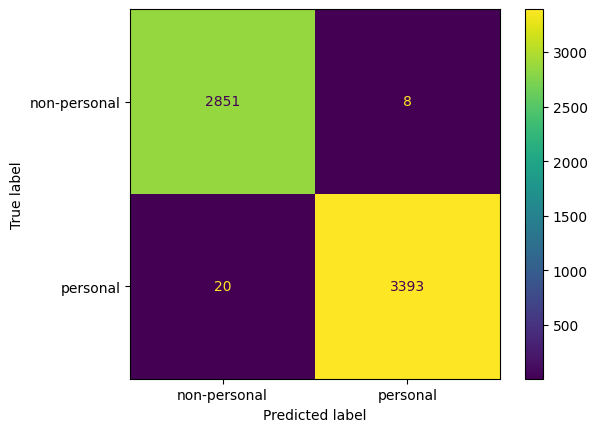

In [187]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cmdessi = confusion_matrix(results_df_test_dess1["True Label"],results_df_test_dess1["Prediction"])
disp1 = ConfusionMatrixDisplay(confusion_matrix=cmdessi, display_labels=['non-personal', 'personal'])
disp1.plot()
plt.show()

# Kaggle Datasets

In [188]:
test_kaggle = pd.read_csv("../../datasets/kaggle_datasets/all_datasets.csv")
test_kaggle_personal = pd.read_csv("../../datasets/kaggle_datasets/all_datasets_labels_personal.csv")

In [189]:
kaggle_true = pd.read_csv("../CASSED_model_results/cassed_personal/kaggle/true.csv")
kaggle_pred = pd.read_csv("../CASSED_model_results/cassed_personal/kaggle/predicted.csv")
kaggle_target_names = pd.read_csv("../CASSED_model_results/cassed_personal/kaggle/target_names.csv")
kaggle_target_names = {a[1]: a[0] for a in kaggle_target_names[["0", "0.1"]].values}
kaggle_target_names[0] = "no prediction"

In [190]:
kaggle_target_names

{2: 'non-personal', 1: 'personal', 0: 'no prediction'}

In [191]:
predictions, true = [], []
for i in range(kaggle_true.shape[0]):
    predictions.append([kaggle_target_names[e] for e, b in enumerate(kaggle_pred.iloc[i,:]) if b == 1])
    true.append([kaggle_target_names[e] for e, b in enumerate(kaggle_true.iloc[i,:]) if b == 1])
true = [a[0] for a in true]
predictions = [a[0] for a in predictions]

In [192]:
predictions

['non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'personal',
 'personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'personal',
 'personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-personal',
 'non-pe

In [193]:
plot_cassed_results(true, predictions)

In [194]:
results_df_test_kaggle1 = pd.DataFrame({
    "Column": test_kaggle.columns,
    "Prediction": predictions,
    "True Label": test_kaggle_personal["label"].values
    })

In [195]:
#False negatives -- personal --> personal
fnneg_kag = results_df_test_kaggle1.loc[(results_df_test_kaggle1["True Label"] == "personal") & (results_df_test_kaggle1["Prediction"] == "non-personal")]
fnneg_kag

,Column,Prediction,True Label
0,ID,non-personal,personal
1,Reason for absence,non-personal,personal
2,Month of absence,non-personal,personal
3,Day of the week,non-personal,personal
4,Seasons,non-personal,personal
...,...,...,...
230,Parch,non-personal,personal
231,Ticket,non-personal,personal
232,Fare,non-personal,personal
233,Cabin,non-personal,personal


In [ ]:
test_kaggle[fnneg_kag]

In [196]:
# false positive -- non personal --> personal
falsep_kag = results_df_test_kaggle1.loc[(results_df_test_kaggle1["True Label"] == "non-personal") & (results_df_test_kaggle1["Prediction"] == "personal")]
falsep_kag

,Column,Prediction,True Label
41,Soil type,personal,non-personal
111,fullAddress,personal,non-personal
112,postcode,personal,non-personal
114,outcode,personal,non-personal
151,REGISTERED_OFFICE_ADDRESS,personal,non-personal
153,EMAIL_ADDR,personal,non-personal
174,movie,personal,non-personal
178,plot_summary,personal,non-personal
179,director,personal,non-personal
180,writer,personal,non-personal


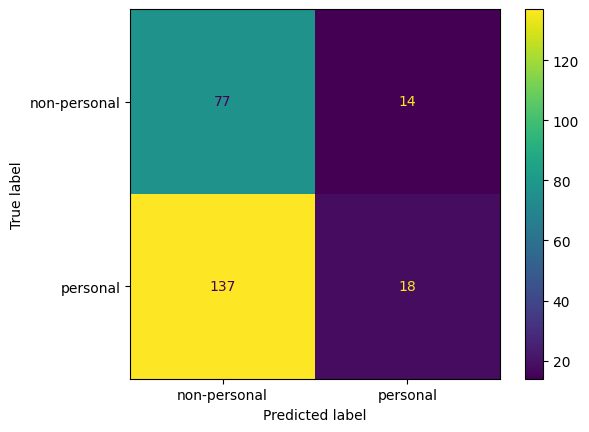

In [197]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cmkag = confusion_matrix(results_df_test_kaggle1["True Label"],results_df_test_kaggle1["Prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cmkag, display_labels=['non-personal', 'personal'])
disp.plot()
plt.show()

In [198]:
f1_micro_kag = f1_score(results_df_test_kaggle1["True Label"],results_df_test_kaggle1["Prediction"], average='micro')
print(f'f1_score micro:{np.round(f1_micro_kag,3)}')
f1_macro_kag = f1_score(results_df_test_kaggle1["True Label"],results_df_test_kaggle1["Prediction"], average='macro')
print(f'f1_score micro:{np.round(f1_macro_kag,3)}')
bal_kag = balanced_accuracy_score(results_df_test_kaggle1["True Label"],results_df_test_kaggle1["Prediction"])
print(f'Balanced Acc.: {np.round(bal_kag,3)}')
print(classification_report(results_df_test_kaggle1["True Label"],results_df_test_kaggle1["Prediction"]))

f1_score micro:0.386
f1_score micro:0.349
Balanced Acc.: 0.481
              precision    recall  f1-score   support

non-personal       0.36      0.85      0.50        91
    personal       0.56      0.12      0.19       155

    accuracy                           0.39       246
   macro avg       0.46      0.48      0.35       246
weighted avg       0.49      0.39      0.31       246



In [199]:
print(classification_report(test_kaggle_personal,results_df_test_kaggle1["Prediction"]))


              precision    recall  f1-score   support

non-personal       0.36      0.85      0.50        91
    personal       0.56      0.12      0.19       155

    accuracy                           0.39       246
   macro avg       0.46      0.48      0.35       246
weighted avg       0.49      0.39      0.31       246



In [272]:
FNcaskag = results_df_test_kaggle1.loc[(results_df_test_kaggle1["True Label"]=='personal')&(results_df_test_kaggle1["Prediction"]=='non-personal')]

In [274]:
test_kaggle[FNcaskag.Column]

,ID,Reason for absence,Month of absence,Day of the week,Seasons,Transportation expense,Distance from Residence to Work,Service time,Age,Work load Average/day,...,PassengerId,Survived,Pclass,Age.3,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,11,26,7,3,1,289,36,13,33,239.554,...,1,0,3,22.0,1,0,A/5 21171,7.2500,NaN,S
1,36,0,7,3,1,118,13,18,50,239.554,...,2,1,1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,23,7,4,1,179,51,18,38,239.554,...,3,1,3,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,7,7,7,5,1,279,5,14,39,239.554,...,4,1,1,35.0,1,0,113803,53.1000,C123,S
4,11,23,7,5,1,289,36,13,33,239.554,...,5,0,3,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,28,28,11,3,4,225,26,9,28,306.345,...,96,0,3,NaN,0,0,374910,8.0500,NaN,S
96,11,7,11,4,4,289,36,13,33,306.345,...,97,0,1,71.0,0,0,PC 17754,34.6542,A5,C
97,15,23,11,5,4,291,31,12,40,306.345,...,98,1,1,23.0,0,1,PC 17759,63.3583,D10 D12,C
98,33,23,12,3,4,248,25,14,47,261.306,...,99,1,2,34.0,0,1,231919,23.0000,NaN,S


In [276]:
FPcaskag = results_df_test_kaggle1.loc[(results_df_test_kaggle1["True Label"]=='non-personal')&(results_df_test_kaggle1["Prediction"]=='personal')]

In [277]:
test_kaggle[FPcaskag.Column]

,Soil type,fullAddress,postcode,outcode,REGISTERED_OFFICE_ADDRESS,EMAIL_ADDR,movie,plot_summary,director,writer,main_characters,main_voice_actors,model,kmDriven
0,Alluvial,"1 Guinness Court, Mansell Street, London, E1 8AB",E1 8AB,E1,"4TH FLOOR,LANDMARKRACE COURSE",SANJAY@NIKOINDIA.COM,Toy Story,"A group of toys, headed by Woody, a pull-strin...",John Lasseter,"John Lasseter, Pete Docter, Andrew Stanton, Jo...","Woody, Buzz Lightyear, Andy, Mr. Potato Head, ...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney",City,"98,000 km"
1,Alluvial,"306 Marlyn Lodge, 2 Portsoken Street, London, ...",E1 8RB,E1,403 3 6 322 MAHAVIR HOUSEBUSHEER BAGH HYDERGUD...,NaN,A Bug's Life,A misfit ant named Flik teams up with a group ...,"John Lasseter, co-directed by Andrew Stanton","Andrew Stanton, Joe Ranft","Flik, Princess Atta, Hopper, Dot, Manny, Gypsy","Dave Foley, Julia Louis-Dreyfus, Kevin Spacey,...",Innova,190000.0 km
2,Alluvial,"Flat 1, White Rose Court, Widegate Street, Lon...",E1 7ES,E1,"Quadrant 1, Plot Number 18, 2nd FloorSuman Tow...",info@nangia.com,Toy Story 2,"When Woody is stolen by a toy collector, Buzz ...","John Lasseter, Ash Brannon, Lee Unkrich","John Lasseter, Andrew Stanton, Pete Docter, As...","Woody, Buzz Lightyear, Jessie, Bullseye, Stink...","Tom Hanks, Tim Allen, Joan Cusack, Kelsey Grammer",VentoTest,"77,246 km"
3,Alluvial,"Flat 1, White Rose Court, Widegate Street, Lon...",E1 7ES,E1,"Plot No. 3526 & 3527,GIDC Industrial Estate,",amit.kumashi@solvay.com,"Monsters, Inc.",In a world where monsters generate energy by s...,"Pete Docter, David Silverman, Lee Unkrich","Pete Docter, Jill Culton, Jeff Pidgeon, Ralph ...","James P. Sullivan (Sulley), Mike Wazowski, Boo...","John Goodman, Billy Crystal, Mary Gibbs, Steve...",Swift,"83,500 km"
4,Alluvial,"Flat 1, White Rose Court, Widegate Street, Lon...",E1 7ES,E1,24 ATMAJYOTI NAGARELLORA PARK,NaN,Finding Nemo,A clownfish named Marlin embarks on a journey ...,"Andrew Stanton, Lee Unkrich","Andrew Stanton, Bob Peterson, David Reynolds","Marlin, Nemo, Dory, Gill, Crush","Albert Brooks, Ellen DeGeneres, Alexander Goul...",Baleno,"45,000 km"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Black,"Flat 2, 4 Gunthorpe Street, London, E1 7RQ",E1 7RQ,E1,"401, ""Akshay"", 53, Shrimali Society,Navrangpura",info@amoldicalite.com,NaN,NaN,NaN,NaN,NaN,NaN,Alto-K10,"82,000 km"
96,Black,"Flat 10, 4 Gunthorpe Street, London, E1 7RQ",E1 7RQ,E1,"SHOP NO. 4, AL-MANSOOR COMPLEX, NEAR AL-SAFIQM...",INVESTOR.RELATIONS@BLAZONMARBLESLTD.COM,NaN,NaN,NaN,NaN,NaN,NaN,Celerio,"35,000 km"
97,Black,"Flat 10, 4 Gunthorpe Street, London, E1 7RQ",E1 7RQ,E1,996 KHADIA CHAR RASTA,mohlimited@hotmail.com,NaN,NaN,NaN,NaN,NaN,NaN,Duster,"150,000 km"
98,Black,"Flat 24, Wentworth Dwellings, 3 New Goulston S...",E1 7PN,E1,"SHREE CHAMBERS, 3rd FLOOR, OPP KAMALA NEHRU PA...",scabalshare@scabalindia.com,NaN,NaN,NaN,NaN,NaN,NaN,Fortuner,"132,000 km"


In [275]:
list(FNcaskag.Column)

['ID',
 'Reason for absence',
 'Month of absence',
 'Day of the week',
 'Seasons',
 'Transportation expense',
 'Distance from Residence to Work',
 'Service time',
 'Age',
 'Work load Average/day ',
 'Hit target',
 'Disciplinary failure',
 'Education',
 'Son',
 'Pet',
 'Weight',
 'Height',
 'Absenteeism time in hours',
 'age',
 'workclass',
 'education',
 'education.num',
 'marital.status',
 'occupation',
 'relationship',
 'capital.gain',
 'capital.loss',
 'hours.per.week',
 'native.country',
 'income',
 'age.1',
 'job',
 'marital',
 'education.1',
 'default',
 'housing',
 'loan',
 'month',
 'day_of_week',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'y',
 'Age.1',
 'Polyuria',
 'Polydipsia',
 'sudden weight loss',
 'weakness',
 'Polyphagia',
 'Genital thrush',
 'visual blurring',
 'Itching',
 'Irritability',
 'delayed healing',
 'partial paresis',
 'muscle stiffness',
 'Alopecia',
 'Obesity',
 'class',
 'Serial No.',
 'GRE Score',
 'TOEFL Score',
 'SOP',
 'LOR ',
 'CG

        Label revision, for kaggle

In [200]:
rev_resultkag= results_df_test_kaggle1.copy()

In [201]:
rev_resultkag.columns

Index(['Column', 'Prediction', 'True Label'], dtype='object')

In [202]:

rev_resultkag['True Label Fixed'] = rev_resultkag['True Label']

# List of elements to be replaced with 'non-personal'
non_personal_elements1 = non_personal_columns = [
    'Month of absence', 'Day of the week', 'Seasons', 'Work load Average/day', 
    'Hit target', 'Disciplinary failure', 'Education', 'Social drinker', 
    'Social smoker', 'Pet', 'Absenteeism time in hours', 'Workclass', 
    'Education.num', 'Occupation', 'Capital.gain', 'Capital.loss', 
    'Hours.per.week', 'Income', 'Job', 'Housing', 'Loan', 'Contact', 'Month', 
    'Day_of_week', 'Duration', 'Campaign', 'Pdays', 'Previous', 'Poutcome', 
    'Y', 'Research', 'Dataset', 'CP', 'Trestbps', 'Chol', 'Fbs', 'Restecg', 
    'Thalch', 'Exang', 'Oldpeak', 'Slope', 'Ca', 'Thal', 'Num', 'Label', 
    'School', 'G1', 'G2', 'G3', 'Pclass', 'Device IDs', 'Masked IP addresses', 
    'Aggregated statistics', 'Age range', 'Census data', 'Tax receipts', 
    'Weather conditions', 'Product information', 'Service information'
]

# Replace the specified elements with 'non-personal' in the new column
rev_resultkag.loc[rev_resultkag['Column'].isin(non_personal_elements1), 'True Label Fixed'] = 'non-personal'


In [203]:
rev_resultkag

,Column,Prediction,True Label,True Label Fixed
0,ID,non-personal,personal,personal
1,Reason for absence,non-personal,personal,personal
2,Month of absence,non-personal,personal,non-personal
3,Day of the week,non-personal,personal,non-personal
4,Seasons,non-personal,personal,non-personal
...,...,...,...,...
241,Owner,non-personal,non-personal,non-personal
242,FuelType,non-personal,non-personal,non-personal
243,PostedDate,non-personal,non-personal,non-personal
244,AdditionInfo,non-personal,non-personal,non-personal


In [204]:
rev_resultkag['True Label Fixed'].value_counts()

True Label Fixed
personal        139
non-personal    107
Name: count, dtype: int64

In [205]:
from sklearn.metrics import f1_score

f1 = f1_score(rev_resultkag['True Label Fixed'].values, rev_resultkag['Prediction'].values, average= 'micro')


In [206]:
f1

0.4349593495934959

In [207]:
f1_score(rev_resultkag['True Label Fixed'].values,rev_resultkag['Prediction'].values, average='macro')

0.377056348035197

In [208]:
balanced_accuracy_score(rev_resultkag['True Label Fixed'].values,rev_resultkag['Prediction'].values)

0.4827876016943454

In [209]:
fnneg_kag

,Column,Prediction,True Label
0,ID,non-personal,personal
1,Reason for absence,non-personal,personal
2,Month of absence,non-personal,personal
3,Day of the week,non-personal,personal
4,Seasons,non-personal,personal
...,...,...,...
230,Parch,non-personal,personal
231,Ticket,non-personal,personal
232,Fare,non-personal,personal
233,Cabin,non-personal,personal


In [210]:
#False negatives -- non- personal --> personal
fnneg_kag1 = rev_resultkag.loc[(rev_resultkag["True Label Fixed"] == "personal") & (rev_resultkag["Prediction"] == "non-personal")]
fnneg_kag1

,Column,Prediction,True Label,True Label Fixed
0,ID,non-personal,personal,personal
1,Reason for absence,non-personal,personal,personal
5,Transportation expense,non-personal,personal,personal
6,Distance from Residence to Work,non-personal,personal,personal
7,Service time,non-personal,personal,personal
...,...,...,...,...
230,Parch,non-personal,personal,personal
231,Ticket,non-personal,personal,personal
232,Fare,non-personal,personal,personal
233,Cabin,non-personal,personal,personal


In [211]:
test_kaggle['Education']

0     1
1     1
2     1
3     1
4     1
     ..
95    1
96    1
97    1
98    1
99    1
Name: Education, Length: 100, dtype: int64

## OPEN ML 

In [212]:
# test_openml = pd.read_csv("../../datasets/openml_datasets/all_datasets.csv")
# test_openml_personal = pd.read_csv("../../datasets/openml_datasets/all_datasets_labels_personal.csv")

In [213]:
# openml_true = pd.read_csv("../CASSED_model_results/cassed_personal/openml/true.csv")
# openml_pred = pd.read_csv("../CASSED_model_results/cassed_personal/openml/predicted.csv")
# openml_target_names = pd.read_csv("../CASSED_model_results/cassed_personal/openml/target_names.csv")
# openml_target_names = {a[1]: a[0] for a in openml_target_names[["0", "0.1"]].values}
# openml_target_names[0] = "no prediction"

In [214]:
# predictions, true = [], []
# for i in range(openml_true.shape[0]):
#     predictions.append([openml_target_names[e] for e, b in enumerate(openml_pred.iloc[i,:]) if b == 1])
#     true.append([openml_target_names[e] for e, b in enumerate(openml_true.iloc[i,:]) if b == 1])
# true = [a[0] for a in true]
# predictions = [a[0] for a in predictions]

In [215]:
# plot_cassed_results(true, predictions)

In [216]:
# folders = [name for name in os.listdir("../../datasets/openml_datasets") if os.path.isdir(os.path.join("../../datasets/openml_datasets", name))]
# dataset_openml, dataset_openml_info = [], []
# dataset_type = ["pii info", "personal info", "non-personal info", "personal info", "personal info", "pii info", "pii info", "non-personal info",
#                 "non-personal info", "personal info", "pii info", "non-personal info", "personal info", "pii info", "non-personal info"]
# for e, folder in enumerate(folders):
#     path = "../../datasets/openml_datasets/" + folder
#     csv_file = [f for f in os.listdir(path) if f.endswith('.csv') and 'labels' not in f][0]
#     with open(path + "/" + csv_file, 'r') as file:
#         first_line = file.readline()
#         comma_count = first_line.count(',')
#         semicolon_count = first_line.count(';')
#         if comma_count > semicolon_count:
#             sep = ","
#         else:
#             sep = ";"
#     df = pd.read_csv(path + "/" + csv_file, sep=sep,low_memory=False)
#     dataset_openml += [folder] * df.shape[1]
#     dataset_openml_info += [dataset_type[e]] * df.shape[1]

In [217]:
# results_df_test_openml = pd.DataFrame({
#     "Column": test_openml.columns,
#     "Prediction": predictions,
#     "True Label": test_openml_personal["label"].values,
#     "Dataset": dataset_openml,
#     "Dataset Type": dataset_openml_info
# })

In [218]:
#False negatives
# results_df_test_openml.loc[(results_df_test_openml["True Label"] == "personal") & (results_df_test_openml["Prediction"] == "non-personal")]

In [219]:
#False positives
# results_df_test_openml.loc[(results_df_test_openml["True Label"] == "non-personal") & (results_df_test_openml["Prediction"] == "personal")]

# OpenML 2

In [220]:
# test_openml_2 = pd.read_csv("../../datasets/openml_datasets_2/all_datasets.csv")
# test_openml_2_personal = pd.read_csv("../../datasets/openml_datasets_2/all_datasets_labels_personal.csv")

In [221]:
# openml_2_true = pd.read_csv("../CASSED_model_results/cassed_personal/openml_2/true.csv")
# openml_2_pred = pd.read_csv("../CASSED_model_results/cassed_personal/openml_2/predicted.csv")
# openml_2_target_names = pd.read_csv("../CASSED_model_results/cassed_personal/openml_2/target_names.csv")
# openml_2_target_names = {a[1]: a[0] for a in openml_2_target_names[["0", "0.1"]].values}
# openml_2_target_names[0] = "no prediction"

In [222]:
# predictions, true = [], []
# for i in range(openml_2_true.shape[0]):
#     predictions.append([openml_2_target_names[e] for e, b in enumerate(openml_2_pred.iloc[i,:]) if b == 1])
#     true.append([openml_2_target_names[e] for e, b in enumerate(openml_2_true.iloc[i,:]) if b == 1])
# true = [a[0] for a in true]
# predictions = [a[0] for a in predictions]

In [223]:
# plot_cassed_results(true, predictions)

In [224]:
# folders = [name for name in os.listdir("../../datasets/openml_datasets_2") if os.path.isdir(os.path.join("../../datasets/openml_datasets_2", name))]
# dataset_openml_2, dataset_openml_2_info = [], []
# dataset_type = ["pii info", "personal info", "non-personal info", "personal info", "personal info", "pii info", "pii info", "non-personal info",
#                 "non-personal info", "personal info", "pii info", "non-personal info", "personal info", "pii info", "non-personal info"]
# for e, folder in enumerate(folders):
#     path = "../../datasets/openml_datasets_2/" + folder
#     csv_file = [f for f in os.listdir(path) if f.endswith('.csv') and 'labels' not in f][0]
#     with open(path + "/" + csv_file, 'r') as file:
#         first_line = file.readline()
#         comma_count = first_line.count(',')
#         semicolon_count = first_line.count(';')
#         if comma_count > semicolon_count:
#             sep = ","
#         else:
#             sep = ";"
#     df = pd.read_csv(path + "/" + csv_file, sep=sep)
#     dataset_openml_2 += [folder] * df.shape[1]
#     dataset_openml_2_info += [dataset_type[e]] * df.shape[1]

In [225]:
# results_df_test_openml_2 = pd.DataFrame({
#     "Column": test_openml_2.columns,
#     "Prediction": predictions,
#     "True Label": test_openml_2_personal["label"].values,
#     "Dataset": dataset_openml_2,
#     "Dataset Type": dataset_openml_2_info
# })

In [226]:
# #False negatives
# results_df_test_openml_2.loc[(results_df_test_openml_2["True Label"] == "personal") & (results_df_test_openml_2["Prediction"] == "non-personal")]

In [227]:
# #False positives
# results_df_test_openml_2.loc[(results_df_test_openml_2["True Label"] == "non-personal") & (results_df_test_openml_2["Prediction"] == "personal")]

# Medical

In [228]:
# test_medical = pd.read_csv("../../datasets/freiburg-medical/test.csv")
# test_medical_personal = pd.read_csv("../../datasets/freiburg-medical/test_labels_personal.csv")

In [229]:
# medical_true = pd.read_csv("../CASSED_model_results/cassed_personal/medical/true.csv")
# medical_pred = pd.read_csv("../CASSED_model_results/cassed_personal/medical/predicted.csv")
# medical_target_names = pd.read_csv("../CASSED_model_results/cassed_personal/medical/target_names.csv")
# medical_target_names = {a[1]: a[0] for a in medical_target_names[["0", "0.1"]].values}
# medical_target_names[0] = "no prediction"

In [230]:
# predictions, true = [], []
# for i in range(medical_true.shape[0]):
#     predictions.append([medical_target_names[e] for e, b in enumerate(medical_pred.iloc[i,:]) if b == 1])
#     true.append([medical_target_names[e] for e, b in enumerate(medical_true.iloc[i,:]) if b == 1])
# true = [a[0] for a in true]
# predictions = [a[0] for a in predictions]

In [231]:
# y_true = true
# y_pred = predictions
# y_true_bin = [1 if label == "personal" else 0 for label in y_true]
# y_pred_bin = [1 if label == "personal" else 0 for label in y_pred]

# cm = confusion_matrix(y_true, y_pred, labels=["personal", "non-personal"])
# cm_norm = confusion_matrix(y_true, y_pred, labels=["personal", "non-personal"], normalize="true")

# accuracy = accuracy_score(y_true, y_pred)
# f1 = f1_score(y_true, y_pred, average="weighted")
# precision = precision_score(y_true, y_pred, average="weighted", zero_division=0)
# recall = recall_score(y_true, y_pred, average="weighted", zero_division=0)

# fig = make_subplots(
#     rows=1, cols=2, 
#     subplot_titles=["Evaluation Metrics", "Confusion Matrix"]
# )

# metrics = {
#     "weighted Precision": precision,
#     "weighted Recall": recall,
#     "weighted F1 Score": f1,
#     "Accuracy": accuracy
# }

# fig.add_trace(go.Bar(
#     x=list(metrics.keys()),
#     y=list(metrics.values()), 
#     showlegend=False
# ), row=1, col=1)

# text_values = [
#     [f"{cm[0,0]}<br>{cm_norm[0,0]:.2f}", f"{cm[0,1]}<br>{cm_norm[0,1]:.2f}"],
#     [f"{cm[1,0]}<br>{cm_norm[1,0]:.2f}", f"{cm[1,1]}<br>{cm_norm[1,1]:.2f}"]
# ]
# cm_heatmap = go.Heatmap(
#     z=cm, 
#     x=["Pred: personal", "Pred: non-personal"], 
#     y=["True: personal", "True: non-personal"], 
#     colorscale="Blues", 
#     showscale=False,
#     text=text_values, 
#     texttemplate="%{text}",
#     textfont={"size":20},
# )


# fig.add_trace(cm_heatmap, row=1, col=2)

# fig.update_layout(
#     title="Confusion Matrix and Evaluation Metrics",
#     height=500, 
#     width=1000,
#     showlegend=False
# )
# fig.update_yaxes(range=[0, 1.1], row=1, col=1)

# fig.show()

In [232]:
# y_true

In [233]:
# results_df_test_medical = pd.DataFrame({
#     "Column": test_medical.columns,
#     "Prediction": predictions,
#     "True Label": test_medical_personal["label"].values
# })

In [234]:
# #False negatives
# results_df_test_medical.loc[(results_df_test_medical["True Label"] == "personal") & (results_df_test_medical["Prediction"] == "non-personal")]

In [235]:
# #False positives
# results_df_test_medical.loc[(results_df_test_medical["True Label"] == "non-personal") & (results_df_test_medical["Prediction"] == "personal")]

# OpenML

 # OPENML ALL

In [236]:
import os

absolute_path = "/home/aagisha/Documents/PhD Albert/CodingPhDStart1/WorkshopSIGMOD/Personal-Detection/CASSED/CASSED_model_results/cassed_personal/openmlall/predicted.csv"

# Get relative path from the current working directory
relative_path = os.path.relpath(absolute_path, os.getcwd())

print(relative_path)

../CASSED_model_results/cassed_personal/openmlall/predicted.csv


In [237]:
test_openmlall = pd.read_csv("../../datasets/OpenMLall_data/OpenMLAll_data.csv")
test_openmlall_personal = pd.read_csv("../../datasets/OpenMLall_data/OpenMLAll_data_labels.csv")

In [238]:
openmlall_true = pd.read_csv("../CASSED_model_results/cassed_personal/openmlall/true.csv")
openmlall_pred = pd.read_csv("../CASSED_model_results/cassed_personal/openmlall/predicted.csv")
openmlall_target_names = pd.read_csv("../CASSED_model_results/cassed_personal/openmlall/target_names.csv")
openmlall_target_names = {a[1]: a[0] for a in openmlall_target_names[["0", "0.1"]].values}
openmlall_target_names[0] = "no prediction"

In [239]:
openmlall_target_names

{2: 'non-personal', 1: 'personal', 0: 'no prediction'}

In [240]:
predictionsopenml, trueopenml = [], []
for i in range(openmlall_true.shape[0]):
    predictionsopenml.append([openmlall_target_names[e] for e, b in enumerate(openmlall_pred.iloc[i,:]) if b == 1])
    trueopenml.append([openmlall_target_names[e] for e, b in enumerate(openmlall_true.iloc[i,:]) if b == 1])
trueopenml = [a[0] for a in trueopenml]
predictionsopenml = [a[0] for a in predictionsopenml]

In [241]:
plot_cassed_results(trueopenml, predictionsopenml)

In [242]:

results_df_test_openmlall = pd.DataFrame({
    "Column": test_openmlall.columns,
    "Prediction": predictionsopenml,
    "True Label": trueopenml#test_openmlall_personal["label"].values
    })

In [243]:
results_df_test_openmlall

,Column,Prediction,True Label
0,User ID,non-personal,personal
1,Name,non-personal,personal
2,Email Address,non-personal,personal
3,Username,non-personal,personal
4,Date of Birth,non-personal,personal
...,...,...,...
253,density,non-personal,non-personal
254,pH,non-personal,non-personal
255,sulphates,non-personal,non-personal
256,alcohol,non-personal,non-personal


In [278]:
fnneg_openmlall

,Column,Prediction,True Label
0,User ID,non-personal,personal
1,Name,non-personal,personal
2,Email Address,non-personal,personal
3,Username,non-personal,personal
4,Date of Birth,non-personal,personal
...,...,...,...
162,wall_score,non-personal,personal
163,wall_index,non-personal,personal
164,alive_at_1,non-personal,personal
165,class,non-personal,personal


In [279]:
test_openmlall[fnneg_openmlall.Column]

,User ID,Name,Email Address,Username,Date of Birth,Location,Membership Start Date,Membership End Date,Subscription Plan,Payment Information,...,age,pericardial,fractional,epss,lvdd,wall_score,wall_index,alive_at_1,class,Speaker Number
0,1,Ronald Murphy,williamholland@example.com,williamholland,1953-06-03,Rebeccachester,2024-01-15,2025-01-14,Annual,Mastercard,...,71.0,0,0.260,9.000,4.600,14.00,1.00,0.0,11.0,Andrew
1,2,Scott Allen,scott22@example.org,scott22,1978-07-08,Mcphersonview,2024-01-07,2025-01-06,Monthly,Visa,...,72.0,0,0.380,6.000,4.100,14.00,1.70,0.0,19.0,Andrew
2,3,Jonathan Parrish,brooke16@example.org,brooke16,1994-12-06,Youngfort,2024-04-13,2025-04-13,Monthly,Mastercard,...,55.0,0,0.260,4.000,3.420,14.00,1.00,0.0,16.0,Andrew
3,4,Megan Williams,elizabeth31@example.net,elizabeth31,1964-12-22,Feliciashire,2024-01-24,2025-01-23,Monthly,Amex,...,60.0,0,0.253,12.062,4.603,16.00,1.45,0.0,57.0,Andrew
4,5,Kathryn Brown,pattersonalexandra@example.org,pattersonalexandra,1961-06-04,Port Deborah,2024-02-14,2025-02-13,Annual,Visa,...,57.0,0,0.160,22.000,5.750,18.00,2.25,0.0,19.0,Andrew
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Mackenzie Harris,andersonemily@example.net,andersonemily,1963-11-06,Lake Barryland,2024-03-01,2025-03-01,Annual,Mastercard,...,59.0,0,0.500,9.100,3.420,18.00,1.50,NaN,33.0,Bill
96,97,Stephanie Potter,heather10@example.org,heather10,1958-05-05,New Teresaburgh,2024-03-25,2025-03-25,Monthly,Amex,...,65.0,1,0.160,8.500,5.470,16.00,1.45,1.0,5.0,Bill
97,98,Mitchell Potter,fsanchez@example.net,fsanchez,1979-08-27,South Katieburgh,2024-01-27,2025-01-26,Annual,Visa,...,58.0,0,0.170,28.900,6.730,26.08,2.01,1.0,4.0,Bill
98,99,Jonathan Rodriguez,nichole85@example.net,nichole85,1967-12-20,East Shannonhaven,2024-02-29,2025-02-28,Monthly,Visa,...,53.0,0,0.170,NaN,4.690,10.00,1.00,NaN,31.0,Bill


In [280]:
test_openmlall[falsep_openmlall.Column]

,opponent,Referee,mcap,Address,Zip,Room,Species,Sex,day
0,Arsenal,C Kavanagh,80237921664,"Blasiusstraat 8 2, Amsterdam",1091 CR,3,1,NaN,fri
1,Fulham,C Kavanagh,1210301944,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,3,1,NaN,tue
2,Southampton,J Moss,203156739099,"Zaaiersweg 11 A, Amsterdam",1097 SM,4,1,NaN,sat
3,Crystal Palace,J Moss,294352563602,"Tenerifestraat 40, Amsterdam",1060 TH,6,1,NaN,fri
4,Leeds,M Oliver,7282794772,"Winterjanpad 21, Amsterdam",1036 KN,5,1,NaN,sun
...,...,...,...,...,...,...,...,...,...
95,Leeds,D Coote,4004650849,"Achillesstraat 113 2, Amsterdam",1076 RA,3,6,0.0,sun
96,Leeds,P Tierney,772279755324,"Parnassusweg 151, Amsterdam",1077 DE,3,6,0.0,sat
97,Aston Villa,P Tierney,26281404602,"Lamarckhof 11 I, Amsterdam",1098 TK,3,6,NaN,sat
98,Man City,A Taylor,31269549947,"Cornelis van Vollenhovenstraat 4 B, Amsterdam",1063 KS,3,6,NaN,sun


In [244]:
test_openmlall['Speaker Number']

0     Andrew
1     Andrew
2     Andrew
3     Andrew
4     Andrew
       ...  
95      Bill
96      Bill
97      Bill
98      Bill
99      Bill
Name: Speaker Number, Length: 100, dtype: object

In [245]:
#False negatives -- personal --> non personal
fnneg_openmlall  = results_df_test_openmlall.loc[(results_df_test_openmlall["True Label"] == "personal") & (results_df_test_openmlall["Prediction"] == "non-personal")]
fnneg_openmlall

,Column,Prediction,True Label
0,User ID,non-personal,personal
1,Name,non-personal,personal
2,Email Address,non-personal,personal
3,Username,non-personal,personal
4,Date of Birth,non-personal,personal
...,...,...,...
162,wall_score,non-personal,personal
163,wall_index,non-personal,personal
164,alive_at_1,non-personal,personal
165,class,non-personal,personal


In [246]:
# false positive -- non personal --> personal
falsep_openmlall = results_df_test_openmlall.loc[(results_df_test_openmlall["True Label"] == "non-personal") & (results_df_test_openmlall["Prediction"] == "personal")]
falsep_openmlall

,Column,Prediction,True Label
20,opponent,personal,non-personal
27,Referee,personal,non-personal
47,mcap,personal,non-personal
86,Address,personal,non-personal
87,Zip,personal,non-personal
90,Room,personal,non-personal
166,Species,personal,non-personal
172,Sex,personal,non-personal
177,day,personal,non-personal


In [247]:
# check details 
test_openmlall['User ID']

0       1
1       2
2       3
3       4
4       5
     ... 
95     96
96     97
97     98
98     99
99    100
Name: User ID, Length: 100, dtype: int64

In [248]:
test_openmlall['Sex']

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
95    0.0
96    0.0
97    NaN
98    NaN
99    NaN
Name: Sex, Length: 100, dtype: float64

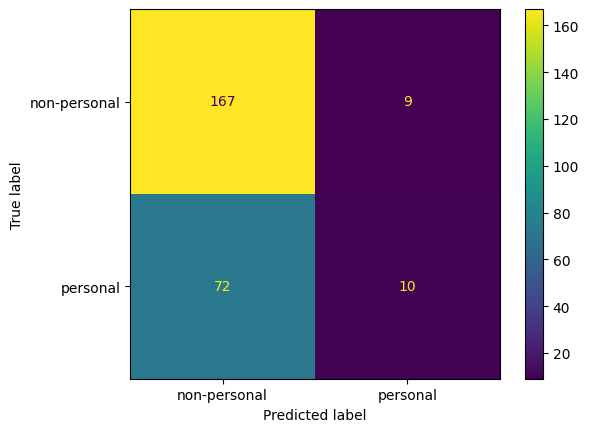

In [249]:
cmopenall = confusion_matrix(results_df_test_openmlall["True Label"],results_df_test_openmlall["Prediction"])
dispopenall = ConfusionMatrixDisplay(confusion_matrix=cmopenall, display_labels=['non-personal', 'personal'])
dispopenall.plot()
plt.show()

In [250]:
f1_micro_open = f1_score(results_df_test_openmlall["True Label"],results_df_test_openmlall["Prediction"], average='micro')
print(f'f1_score micro:{np.round(f1_micro_open,3)}')
f1_macro_open = f1_score(results_df_test_openmlall["True Label"],results_df_test_openmlall["Prediction"], average='macro')
print(f'f1_score macro:{np.round(f1_macro_open,3)}')
bal_open = balanced_accuracy_score(results_df_test_openmlall["True Label"],results_df_test_openmlall["Prediction"])
print(f'Balanced Acc.: {np.round(bal_open,3)}')
print(classification_report(results_df_test_openmlall["True Label"],results_df_test_openmlall["Prediction"]))

f1_score micro:0.686
f1_score macro:0.501
Balanced Acc.: 0.535
              precision    recall  f1-score   support

non-personal       0.70      0.95      0.80       176
    personal       0.53      0.12      0.20        82

    accuracy                           0.69       258
   macro avg       0.61      0.54      0.50       258
weighted avg       0.64      0.69      0.61       258



### MIMIC Ext

In [251]:
import os

absolute_path = "/home/aagisha/Documents/PhD Albert/CodingPhDStart1/WorkshopSIGMOD/Personal-Detection/CASSED/CASSED_model_results/cassed_personal/mimic/predicted.csv"

# Get relative path from the current working directory
relative_path = os.path.relpath(absolute_path, os.getcwd())

print(relative_path)

../CASSED_model_results/cassed_personal/mimic/predicted.csv


In [252]:
test_mimic1 = pd.read_csv("../../datasets/mimic/test.csv")
test_mimic_personal1 = pd.read_csv("../../datasets/mimic/test_labels.csv")
true_mimic1 = pd.read_csv("../CASSED_model_results/cassed_personal/mimic/true.csv")
pred_mimic1 = pd.read_csv("../CASSED_model_results/cassed_personal/mimic/predicted.csv")

In [253]:
mimic_target_names = pd.read_csv("../CASSED_model_results/cassed_personal/mimic/target_names.csv")
mimic_target_names = {a[1]: a[0] for a in mimic_target_names[["0", "0.1"]].values}
mimic_target_names[0] = "no prediction"

In [254]:
predictionsmimic, truemimic = [], []
for i in range(true_mimic1.shape[0]):
    predictionsmimic.append([mimic_target_names[e] for e, b in enumerate(pred_mimic1.iloc[i,:]) if b == 1])
    truemimic.append([mimic_target_names[e] for e, b in enumerate(true_mimic1.iloc[i,:]) if b == 1])
truemimic = [a[0] for a in truemimic]
predictionsmimic = [a[0] for a in predictionsmimic]

In [255]:
plot_cassed_results(truemimic, predictionsmimic)

In [256]:
results_df_test_mimic = pd.DataFrame({
    "Column": test_mimic1.columns,
    "Prediction": predictionsmimic,
    "True Label": test_mimic_personal1["label"].values
    })

In [257]:
#False negatives -- personal --> non personal
fnneg_mimic  = results_df_test_mimic.loc[(results_df_test_mimic["True Label"] == "personal") & (results_df_test_mimic["Prediction"] == "non-personal")]
fnneg_mimic

,Column,Prediction,True Label
1,subject_id,non-personal,personal
2,hadm_id,non-personal,personal
3,icustay_id,non-personal,personal
5,eventtype,non-personal,personal
18,expire_flag,non-personal,personal
41,cgid,non-personal,personal
48,icd9_code,non-personal,personal
71,patientweight,non-personal,personal
86,cpt_number,non-personal,personal
88,ticket_id_seq,non-personal,personal


In [258]:
# false positive -- non personal --> personal
falsep_mimic= results_df_test_mimic.loc[(results_df_test_mimic["True Label"] == "non-personal") & (results_df_test_mimic["Prediction"] == "personal")]
falsep_mimic

,Column,Prediction,True Label
33,value,personal,non-personal
40,storetime,personal,non-personal
80,comments_date,personal,non-personal
83,loinc_code,personal,non-personal
99,subsectionrange,personal,non-personal
101,mincodeinsubsection,personal,non-personal
110,language,personal,non-personal
119,startdate,personal,non-personal
120,enddate,personal,non-personal
149,acknowledgetime,personal,non-personal


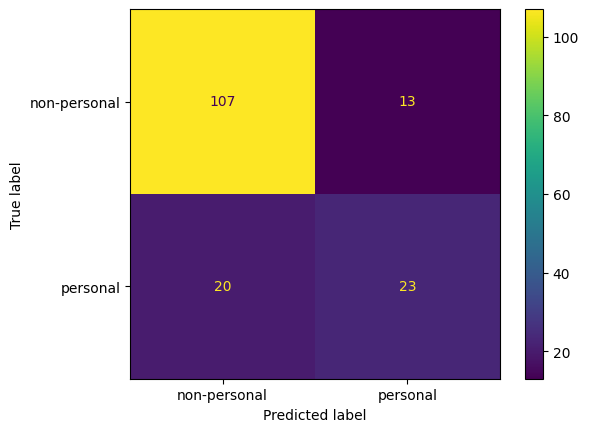

In [259]:
cmmimic = confusion_matrix(results_df_test_mimic["True Label"],results_df_test_mimic["Prediction"])
dispmimic = ConfusionMatrixDisplay(confusion_matrix=cmmimic, display_labels=['non-personal', 'personal'])
dispmimic.plot()
plt.show()


In [260]:
f1_micro_mimic = f1_score(results_df_test_mimic["True Label"],results_df_test_mimic["Prediction"], average='micro')
print(f'f1_score micro:{np.round(f1_micro_mimic,3)}')
f1_macro_mimic = f1_score(results_df_test_mimic["True Label"],results_df_test_mimic["Prediction"], average='macro')
print(f'f1_score macro:{np.round(f1_macro_mimic,3)}')
bal_mimic = balanced_accuracy_score(results_df_test_mimic["True Label"],results_df_test_mimic["Prediction"])
print(f'Balanced Acc.: {np.round(bal_mimic,3)}')
print(classification_report(results_df_test_mimic["True Label"],results_df_test_mimic["Prediction"]))

f1_score micro:0.798
f1_score macro:0.724
Balanced Acc.: 0.713
              precision    recall  f1-score   support

non-personal       0.84      0.89      0.87       120
    personal       0.64      0.53      0.58        43

    accuracy                           0.80       163
   macro avg       0.74      0.71      0.72       163
weighted avg       0.79      0.80      0.79       163



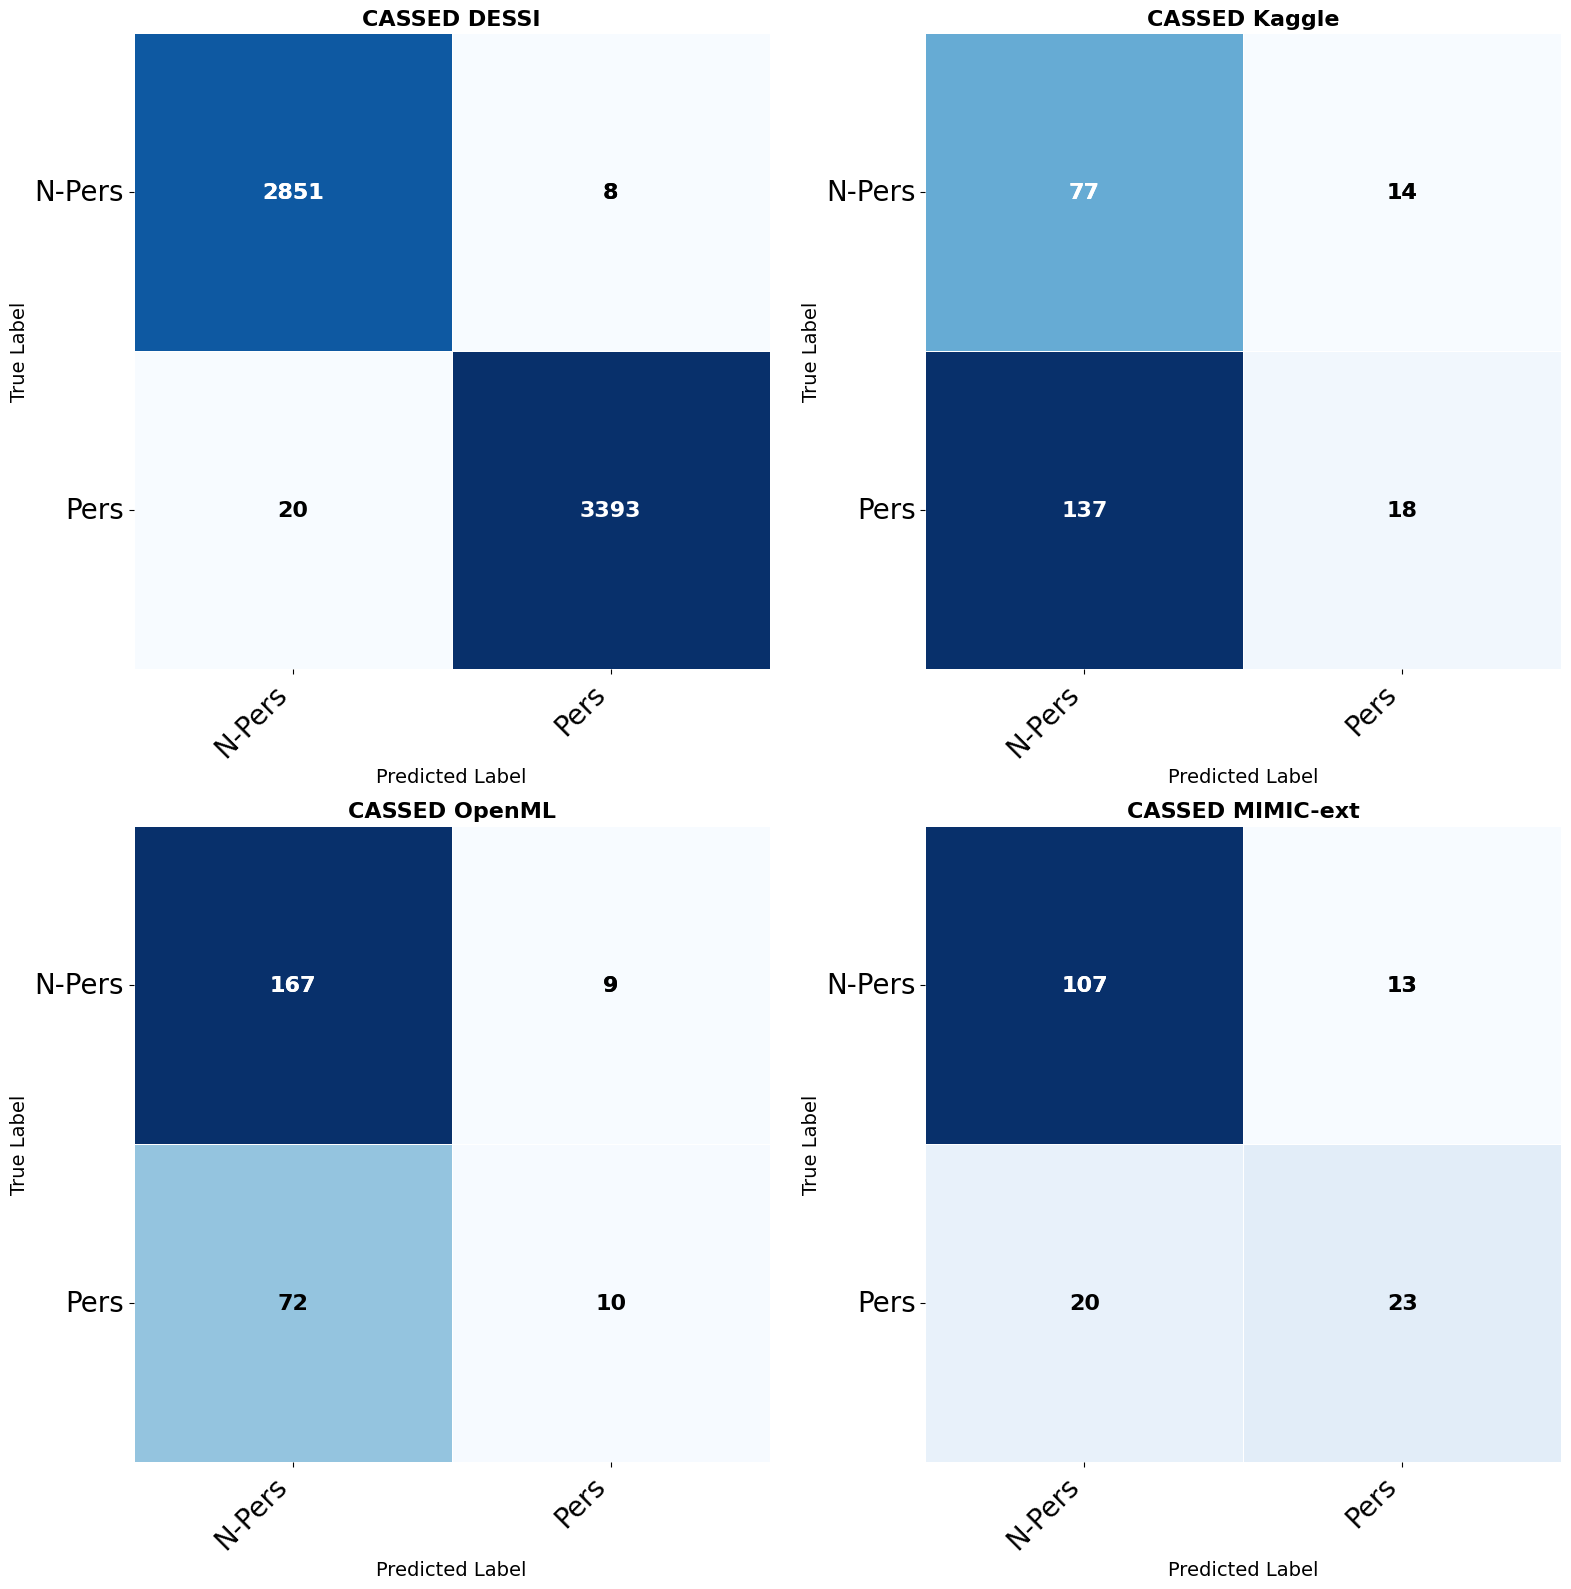

In [261]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(ax, y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=False,
                annot_kws={"size": 16, "weight": "bold"},
                square=True, linewidths=0.5)
    
    # Manually add text for each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j+0.5, i+0.5, str(cm[i, j]),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black",
                    fontsize=16, fontweight='bold')
    
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_ylabel('True Label', fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xticklabels(['N-Pers', 'Pers'], rotation=45, ha='right', fontsize=20)
    ax.set_yticklabels(['N-Pers', 'Pers'], rotation=0, fontsize=20)

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

# Plot each confusion matrix
plot_confusion_matrix(axes[0], results_df_test_dess1["True Label"],results_df_test_dess1["Prediction"], "CASSED DESSI")
plot_confusion_matrix(axes[1], results_df_test_kaggle1["True Label"],results_df_test_kaggle1["Prediction"], "CASSED Kaggle")
plot_confusion_matrix(axes[2], results_df_test_openmlall["True Label"],results_df_test_openmlall["Prediction"], "CASSED OpenML")
plot_confusion_matrix(axes[3], results_df_test_mimic["True Label"],results_df_test_mimic["Prediction"], "CASSED MIMIC-ext")

# Adjust the layout
plt.tight_layout()

# Save the figure as a high-resolution image
plt.savefig("confusion_matrices_cassed1.png", dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

In [262]:
# import os

# absolute_path = "/home/aagisha/Documents/PhD Albert/CodingPhDStart1/WorkshopArticle_1/Experiments/Personal-Detection/datasets/OpenMLall_data/OpenMLAll_data_labels.csv"

# # Get relative path from the current working directory
# relative_path = os.path.relpath(absolute_path, os.getcwd())

# print(relative_path)


In [263]:
# y_trueopenmlall = trueopenml
# y_predopenmlall = predictionsopenml
# y_true_binopenmlall = [1 if label == "personal" else 0 for label in y_trueopenmlall]
# y_pred_binopenmlall = [1 if label == "personal" else 0 for label in y_predopenmlall]

# cmopen = confusion_matrix(y_trueopenmlall, y_predopenmlall, labels=["personal", "non-personal"])
# cm_normopen = confusion_matrix(y_trueopenmlall, y_predopenmlall, labels=["personal", "non-personal"], normalize="true")

# accuracy1 = accuracy_score(y_trueopenmlall, y_predopenmlall)
# f11 = f1_score(y_trueopenmlall, y_predopenmlall, average="weighted")
# precision1 = precision_score(y_trueopenmlall, y_predopenmlall, average="weighted", zero_division=0)
# recall1 = recall_score(y_trueopenmlall, y_predopenmlall, average="weighted", zero_division=0)

# fig1 = make_subplots(
#     rows=1, cols=2, 
#     subplot_titles=["Evaluation Metrics", "Confusion Matrix"]
# )

# metrics1 = {
#     "weighted Precision": precision1,
#     "weighted Recall": recall1,
#     "weighted F1 Score": f11,
#     "Accuracy": accuracy1
# }

# fig1.add_trace(go.Bar(
#     x=list(metrics1.keys()),
#     y=list(metrics1.values()), 
#     showlegend=False
# ), row=1, col=1)

# text_values1 = [
#     [f"{cmopen[0,0]}<br>{cm_normopen[0,0]:.2f}", f"{cmopen[0,1]}<br>{cm_normopen[0,1]:.2f}"],
#     [f"{cmopen[1,0]}<br>{cm_normopen[1,0]:.2f}", f"{cmopen[1,1]}<br>{cm_normopen[1,1]:.2f}"]
# ]
# cm_heatmapopen = go.Heatmap(
#     z=cmopen, 
#     x=["Pred: personal", "Pred: non-personal"], 
#     y=["True: personal", "True: non-personal"], 
#     colorscale="Blues", 
#     showscale=False,
#     text=text_values, 
#     texttemplate="%{text}",
#     textfont={"size":20},
# )


# fig1.add_trace(cm_heatmapopen, row=1, col=2)

# fig1.update_layout(
#     title="Confusion Matrix and Evaluation Metrics",
#     height=500, 
#     width=1000,
#     showlegend=False
# )
# fig1.update_yaxes(range=[0, 1.1], row=1, col=1)

# fig1.show()

In [264]:
# y_trueopenmlall

In [265]:
# predictionsopenml

In [267]:
# import pandas as pd
# import numpy as np

# # Load data
# true_labelsopenML = pd.read_csv("../CASSED_model_results/openmlall/true.csv").values
# predicted_labelsopenML = pd.read_csv("../CASSED_model_results/openmlall/predicted.csv").values
# target_mappingopenML = pd.read_csv("../CASSED_model_results/openmlall/target_names.csv", header=None)

# # Extract class names
# target_classesopenML = target_mappingopenML.iloc[:, 0].values  # ["non-personal", "personal"]

# # Convert one-hot encoding to class labels
# y_true_labelsopenML = np.argmax(true_labelsopenML, axis=1)  # Get the index of 1 in each row
# y_pred_labelsopenML = np.argmax(predicted_labelsopenML, axis=1)

# # Map indices to class names
# y_true_mappedopenML = [target_classesopenML[i] for i in y_true_labelsopenML]
# y_pred_mappedopenML = [target_classesopenML[i] for i in y_pred_labelsopenML]

# # Create DataFrame with mapped labels
# df_resultsopenML = pd.DataFrame({"True_Label": y_true_mappedopenML, "Predicted_Label": y_pred_mappedopenML})

# # Save results
# # df_resultsopenML.to_csv("../CASSED_model_results/openmlall/personal_non_personal_results.csv", index=False)

# print(df_resultsopenML.head())


In [ ]:
target_classesopenML

In [ ]:
f1openallmi = f1_score(y_true_mappedopenML,y_pred_mappedopenML, average= 'micro')
print(f"f1_micro: {np.round(f1openallmi,3)}")
f1openallma = f1_score(y_true_mappedopenML,y_pred_mappedopenML, average= 'macro')
print(f"f1_macro: {np.round(f1openallma,3)}")
f1openallbal = balanced_accuracy_score(y_true_mappedopenML,y_pred_mappedopenML)
print(f"Bal. Acc.: {np.round(f1openallbal,3)}")
print(classification_report(y_true_mappedopenML,y_pred_mappedopenML))

In [ ]:
true_labelsopenML[:120]

In [ ]:
Check_openML = pd.DataFrame({'Features':test_openmlall.columns, 'True_Labels':y_true_mappedopenML, 'Predictions':y_pred_mappedopenML})

## OPEN_ML ANALYSIS

In [ ]:
Check_openML

In [ ]:
test_openmlall_personal

        False Negative

In [ ]:
Check_openML.loc[(Check_openML["True_Labels"]=='personal')]

In [ ]:
check_true = pd.read_csv("/home/aagisha/Documents/PhD Albert/CodingPhDStart1/WorkshopArticle_1/Experiments/CASSED-main/test_results/true.csv")
check_pred = pd.read_csv("/home/aagisha/Documents/PhD Albert/CodingPhDStart1/WorkshopArticle_1/Experiments/CASSED-main/test_results/predicted.csv")

In [ ]:
confusion_matrix(check_true,test_openmlall_personal)

In [ ]:
cmcheck = confusion_matrix(check_true,check_pred)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(confusion_matrix=cmcheck, display_labels=['non-personal', 'personal'])
disp.plot()
plt.show()

# LAST ANALYSIS FOR THE PAPER

## ORIGINAL DATA

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import re
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, roc_auc_score, recall_score, ConfusionMatrixDisplay, classification_report,balanced_accuracy_score
from plotly.subplots import make_subplots
import os

In [ ]:
import os

absolute_path = "/home/aagisha/Documents/PhD Albert/CodingPhDStart1/WorkshopArticle_1/Experiments/Personal-Detection/CASSED/CASSED_model_results/cassed_personal/Openmlall/predicted.csv"

# Get relative path from the current working directory
relative_path = os.path.relpath(absolute_path, os.getcwd())

print(relative_path)


In [ ]:
test_dessi1 = pd.read_csv("../../datasets/dessi_orig/test.csv")
test_dessi_personal1 = pd.read_csv("../../datasets/dessi_orig/test_labels.csv")

test_kaggle1 =pd.read_csv("../../datasets/kaggle_datasets/all_datasets.csv")
test_kaggle1_personal1 = pd.read_csv("../../datasets/kaggle_datasets/all_datasets_labels_personal.csv")

test_openmlall1 = pd.read_csv("../../datasets/OpenMLall_data/OpenMLAll_data.csv")
test_openmlall_personal1 = pd.read_csv("../../datasets/OpenMLall_data/OpenMLAll_data_labels.csv")

test_mimic1 = pd.read_csv("../../datasets/mimic/test.csv")
test_mimic_personal1 = pd.read_csv("../../datasets/mimic/test_labels.csv")

In [ ]:


true_kaggle1 =pd.read_csv("../CASSED_model_results/cassed_personal/kaggle/true.csv")
pred_kaggle1 = pd.read_csv("../CASSED_model_results/cassed_personal/kaggle/predicted.csv")

# test_openmlall1 = pd.read_csv("../../datasets/OpenMLall_data/OpenMLAll_data.csv")
# test_openmlall_personal1 = pd.read_csv("../../datasets/OpenMLall_data/OpenMLAll_data_labels.csv")
# true_openmlall1 = pd.read_csv("../../datasets/OpenMLall_data/OpenMLAll_data.csv")
# pred_openmlall1 = pd.read_csv("../../datasets/OpenMLall_data/OpenMLAll_data_labels.csv")

test_mimic1 = pd.read_csv("../../datasets/mimic/test.csv")
test_mimic_personal1 = pd.read_csv("../../datasets/mimic/test_labels.csv")
true_mimic1 = pd.read_csv("../CASSED_model_results/cassed_personal/Openmlall/predicted.csv")
pred_mimic1 = pd.read_csv("../CASSED_model_results/cassed_personal/Openmlall/predicted.csv")

### DESSI 

In [ ]:
confusion_matrix(true_dessi1,pred_dessi1, labels=['non-personal','personal'])

In [ ]:
are_equal1 = test_dessi_personal1.iloc[:, 0].equals(true_dessi1.iloc[:, 0])
print(are_equal1)  # This will print True


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load datasets
datasets = {
    "DESSI": {
        "features": pd.read_csv("../../datasets/dessi_orig/test.csv"),
        "true": pd.read_csv("../CASSED_model_results/cassed_personal/dessi_orig/true.csv"),
        "pred": pd.read_csv("../CASSED_model_results/cassed_personal/dessi_orig/predicted.csv")
    },
    "KAGGLE": {
        "features": pd.read_csv("../../datasets/kaggle_datasets/all_datasets.csv"),
        "true": pd.read_csv("../CASSED_model_results/cassed_personal/kaggle/true.csv"),
        "pred": pd.read_csv("../CASSED_model_results/cassed_personal/kaggle/predicted.csv")
    },
    "OPENML": {
        "features": pd.read_csv("../../datasets/OpenMLall_data/OpenMLAll_data.csv"),
        "true": pd.read_csv("../CASSED_model_results/cassed_personal/Openmlall/true.csv"),
        "pred": pd.read_csv("../CASSED_model_results/cassed_personal/Openmlall/predicted.csv")
    },
    "MIMIC-ext": {
        "features": pd.read_csv("../../datasets/mimic/test.csv"),
        "true": pd.read_csv("../CASSED_model_results/cassed_personal/mimic/true.csv"),
        "pred": pd.read_csv("../CASSED_model_results/cassed_personal/mimic/predicted.csv")
    }
}

# Store results
results = {}

for name, data in datasets.items():
    df_results = pd.DataFrame({
        "Feature_Name": data["features"].columns,
        "True_Label": data["true"].values.flatten(),  # Already in 'personal' or 'non-personal' format
        "Predicted_Label": data["pred"].values.flatten()
    })
    
    # Identify False Negatives (FN) and False Positives (FP)
    false_negatives = df_results[(df_results["True_Label"] == "personal") & (df_results["Predicted_Label"] == "non-personal")]
    false_positives = df_results[(df_results["True_Label"] == "non-personal") & (df_results["Predicted_Label"] == "personal")]
    
    results[name] = {
        "df": df_results,
        "FN": false_negatives,
        "FP": false_positives
    }

    # Print FN & FP counts
    print(f"\nDataset: {name}")
    print(f"False Negatives (Personal → Non-Personal): {len(false_negatives)}")
    print(false_negatives.head())  # Show FN examples
    print(f"False Positives (Non-Personal → Personal): {len(false_positives)}")
    print(false_positives.head())  # Show FP examples

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(result["df"]["True_Label"], result["df"]["Predicted_Label"], labels=["non-personal", "personal"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Personal", "Personal"], 
                yticklabels=["Non-Personal", "Personal"], ax=axes[i])
    axes[i].set_title(f"{name} Confusion Matrix")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Configure paths and datasets
datasets = {
    "DESSI": {
        "test": "../../datasets/dessi_orig/test.csv",
        "true": "../CASSED_model_results/cassed_personal/dessi_orig/true.csv",
        "pred": "../CASSED_model_results/cassed_personal/dessi_orig/predicted.csv"
    },
    "KAGGLE": {
        "test": "../../datasets/kaggle_datasets/all_datasets.csv", 
        "true": "../CASSED_model_results/cassed_personal/kaggle/true.csv",
        "pred": "../CASSED_model_results/cassed_personal/kaggle/predicted.csv"
    },
    "OPENML": {
        "test": "../../datasets/OpenMLall_data/OpenMLAll_data.csv",
        "true": "../CASSED_model_results/cassed_personal/Openmlall/true.csv",
        "pred": "../CASSED_model_results/cassed_personal/Openmlall/predicted.csv"
    },
    "MIMIC-ext": {
        "test": "../../datasets/mimic/test.csv",
        "true": "../CASSED_model_results/cassed_personal/mimic/true.csv",
        "pred": "../CASSED_model_results/cassed_personal/mimic/predicted.csv"
    }
}

# Initialize results storage
results = {}

for name, paths in datasets.items():
    try:
        # Load data
        test_df = pd.read_csv(paths["test"])
        true_labels = pd.read_csv(paths["true"]).values.flatten()
        pred_labels = pd.read_csv(paths["pred"]).values.flatten()
        
        # Create analysis dataframe
        analysis_df = pd.DataFrame({
            "Feature": test_df.columns,
            "True_Label": true_labels,
            "Predicted_Label": pred_labels
        })
        
        # Calculate errors
        false_negatives = analysis_df[
            (analysis_df["True_Label"] == "personal") & 
            (analysis_df["Predicted_Label"] == "non-personal")
        ]
        
        false_positives = analysis_df[
            (analysis_df["True_Label"] == "non-personal") & 
            (analysis_df["Predicted_Label"] == "personal")
        ]
        
        # Store results
        results[name] = {
            "df": analysis_df,
            "confusion_matrix": confusion_matrix(true_labels, pred_labels, 
                                                labels=["non-personal", "personal"]),
            "false_negatives": false_negatives,
            "false_positives": false_positives
        }
        
        # Print report
        print(f"\n{name} Dataset Analysis:")
        print(f"Total Features: {len(analysis_df)}")
        print(f"False Negatives: {len(false_negatives)}")
        print(false_negatives)
        print(f"False Positives: {len(false_positives)}")
        print(false_positives if not false_positives.empty else "No false negatives")
        print(false_negatives.head(3) if not false_negatives.empty else "No false negatives")
        print(false_positives.head(3) if not false_positives.empty else "No false positives")
        
    except FileNotFoundError as e:
        print(f"\nError processing {name}: {str(e)}")
        continue

# Plot confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, (dataset_name, data) in enumerate(results.items()):
    sns.heatmap(data["confusion_matrix"], 
                annot=True, fmt="d", 
                cmap="Blues",
                ax=axes[idx],
                xticklabels=["Non-Personal", "Personal"],
                yticklabels=["Non-Personal", "Personal"])
    
    axes[idx].set_title(f"{dataset_name} Confusion Matrix\n", fontsize=14)
    axes[idx].set_xlabel("Predicted Labels", fontsize=12)
    axes[idx].set_ylabel("True Labels", fontsize=12)

plt.tight_layout()
plt.show()
